# Import Libraries and Load Clean Data

In [1]:
"""
EduPsyCare Project - Model Training, Finetuning & Evaluation
Objective:
    - Load the preprocessed Student Depression dataset.
    - Define features and target variable.
    - Impute missing values if any.
    - Split the data into training and test sets.
    - Perform wide-range hyperparameter tuning for multiple ML models.
    - Evaluate models using multiple metrics and plots.
    - Select and save the best performing model.

Author: Dang Nguyen Giap
Date: 18-03-2025
Version: 1.0
"""

# Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Import ML libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, auc,
                             precision_recall_curve)
from sklearn.impute import SimpleImputer

import xgboost as xgb  # for XGBoost

# Set style and inline plotting
sns.set(style="whitegrid")
%matplotlib inline

# Load the preprocessed dataset
DATA_CLEAN_PATH = r"G:\FPT University\2025\SPR_25\DAP391m\EduPsyCare\data\Student_Depression_Dataset_clean.csv"
df = pd.read_csv(DATA_CLEAN_PATH)
print("Clean dataset loaded. Shape:", df.shape)


Clean dataset loaded. Shape: (27901, 22)


# Define Features, Target, and Impute Missing Values

In [2]:
features = [
    "Age",
    "CGPA",
    "Work/Study Hours",
    "Sleep Duration Numeric",
    "Gender_encoded",
    "FamilyHistory_encoded",
    "Academic Pressure",
    "Financial Stress",
    "Work Pressure",
    "pressure_index"
]
target = "Depression"

X = df[features]
y = df[target]

# Check missing values
print("Missing values before imputation:\n", X.isnull().sum())

# Impute missing values with mean strategy
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print("Missing values after imputation:\n", X_imputed.isnull().sum())

Missing values before imputation:
 Age                          0
CGPA                         0
Work/Study Hours             0
Sleep Duration Numeric    6062
Gender_encoded               0
FamilyHistory_encoded        0
Academic Pressure            0
Financial Stress             0
Work Pressure                0
pressure_index               0
dtype: int64
Missing values after imputation:
 Age                       0
CGPA                      0
Work/Study Hours          0
Sleep Duration Numeric    0
Gender_encoded            0
FamilyHistory_encoded     0
Academic Pressure         0
Financial Stress          0
Work Pressure             0
pressure_index            0
dtype: int64


# Split Data into Training and Testing Sets

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (22320, 10)
Test set shape: (5581, 10)


# Define Models and Wide Hyperparameter Grids

In [4]:
# Wide grid for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

# Wide grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Wide grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Wide grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Wide grid for ExtraTreesClassifier
param_grid_et = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Create a dictionary mapping model names to (estimator, parameter grid) tuples
models = {
    "LogisticRegression": (LogisticRegression(max_iter=1000), param_grid_lr),
    "RandomForest": (RandomForestClassifier(random_state=42), param_grid_rf),
    "XGBoost": (xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), param_grid_xgb),
    "SVM": (SVC(probability=True, random_state=42), param_grid_svm),
    "ExtraTrees": (ExtraTreesClassifier(random_state=42), param_grid_et)
}

# Hyperparameter Tuning with GridSearchCV (Using n_jobs=1 to Avoid Pickling Issues)

In [5]:
best_estimators = {}  # To store the best estimator for each model
for model_name, (estimator, param_grid) in models.items():
    print(f"\nTuning {model_name} ...")
    # Use n_jobs=1 to avoid pickling errors in multiprocessing
    grid_search = GridSearchCV(estimator, param_grid, cv=5, scoring='f1', n_jobs=1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"{model_name} best parameters: {grid_search.best_params_}")
    print(f"{model_name} best cross-validated F1 score: {grid_search.best_score_:.4f}")


Tuning LogisticRegression ...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
LogisticRegression best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
LogisticRegression best cross-validated F1 score: 0.8218

Tuning RandomForest ...
Fitting 5 folds for each of 45 candidates, totalling 225 fits
RandomForest best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
RandomForest best cross-validated F1 score: 0.8234

Tuning XGBoost ...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\OS\.conda\envs\EduPsyCare\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:43:49] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\OS\.conda\envs\EduPsyCare\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:43:49] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\OS\.conda\envs\EduPsyCare\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:43:49] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\OS\.conda\envs\EduPsyCare\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:43:49] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:

XGBoost best parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
XGBoost best cross-validated F1 score: 0.8248

Tuning SVM ...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
SVM best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVM best cross-validated F1 score: 0.8277

Tuning ExtraTrees ...
Fitting 5 folds for each of 45 candidates, totalling 225 fits
ExtraTrees best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
ExtraTrees best cross-validated F1 score: 0.8201


# Evaluate All Tuned Models on the Test Set

In [6]:
results = {}
for model_name, estimator in best_estimators.items():
    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[model_name] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1 Score": f1}
    print(f"\n{model_name} Performance on Test Set:")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)
    print(classification_report(y_test, y_pred))


LogisticRegression Performance on Test Set:
Accuracy: 0.7792510302813116
Precision: 0.7973130841121495
Recall: 0.8353733170134638
F1 Score: 0.8158995815899582
              precision    recall  f1-score   support

           0       0.75      0.70      0.72      2313
           1       0.80      0.84      0.82      3268

    accuracy                           0.78      5581
   macro avg       0.77      0.77      0.77      5581
weighted avg       0.78      0.78      0.78      5581


RandomForest Performance on Test Set:
Accuracy: 0.7822970793764559
Precision: 0.7984879325385287
Recall: 0.8402692778457772
F1 Score: 0.8188459818100491
              precision    recall  f1-score   support

           0       0.76      0.70      0.73      2313
           1       0.80      0.84      0.82      3268

    accuracy                           0.78      5581
   macro avg       0.78      0.77      0.77      5581
weighted avg       0.78      0.78      0.78      5581


XGBoost Performance on Test Set

# Select and Save the Best Model Based on F1 Score

In [9]:
best_model_name = max(results, key=lambda name: results[name]["F1 Score"])
best_model = best_estimators[best_model_name]
print(f"\nBest model selected: {best_model_name} with F1 Score = {results[best_model_name]['F1 Score']:.4f}")

# Save the best model using joblib
MODEL_PATH = r"/models/depression_model.pkl.pkl"
joblib.dump(best_model, MODEL_PATH)
print("Best model saved to:", MODEL_PATH)


Best model selected: SVM with F1 Score = 0.8214
Best model saved to: G:\FPT University\2025\SPR_25\DAP391m\EduPsyCare\models\best_model.pkl


# Evaluation Visualizations

> Bar Chart comparing F1 Scores for each model

C:\Users\OS\AppData\Local\Temp\ipykernel_9424\3401551270.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=f1_scores, palette="viridis")


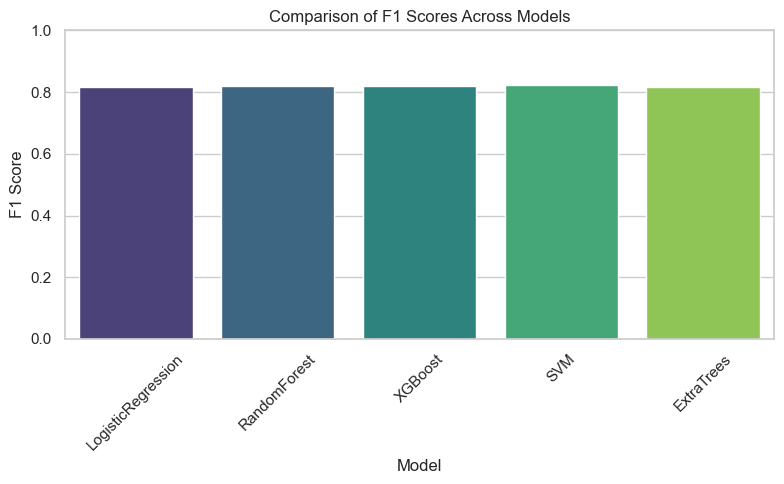

In [10]:
model_names = list(results.keys())
f1_scores = [results[name]["F1 Score"] for name in model_names]

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=f1_scores, palette="viridis")
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.title("Comparison of F1 Scores Across Models")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


> Confusion Matrix for the Best Model

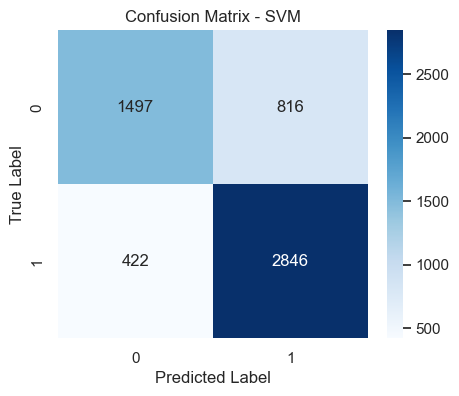

In [11]:
from sklearn.metrics import confusion_matrix

# Predict using the best model
y_pred_best = best_model.predict(X_test)
cm_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_best, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

>  ROC Curve for the Best Model

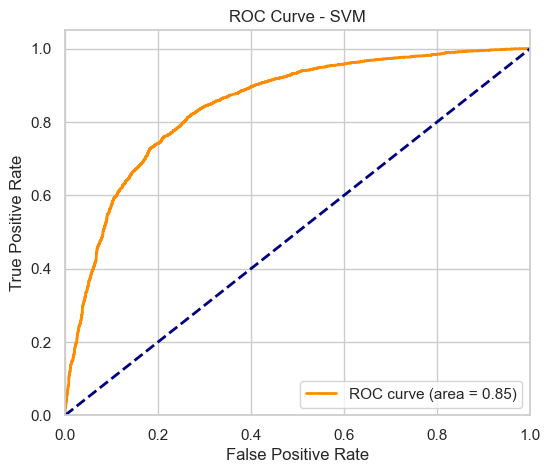

In [12]:
# Ensure that the best model supports probability estimates (SVM, for example, must be set with probability=True)
if hasattr(best_model, "predict_proba"):
    y_pred_prob_best = best_model.predict_proba(X_test)[:, 1]
else:
    # For models like SVM (if probability=False), use decision_function if available
    y_pred_prob_best = best_model.decision_function(X_test)

fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_pred_prob_best)
roc_auc_best = auc(fpr_best, tpr_best)

plt.figure(figsize=(6, 5))
plt.plot(fpr_best, tpr_best, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc_best:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - {best_model_name}")
plt.legend(loc="lower right")
plt.show()